# Apoferritin PDB dataset Phase Retrieval

> Georgios Varnavides | Oct 24 2025  
>
> Sample: apoferritin PDB dataset  
> Sampling conditions: ~10 Ang step-sizes  
> Imaging conditions: 4 mrad, 1.5 um defocus  

In [1]:
import quantem as em
import numpy as np

In [2]:
dataset = em.core.io.load("../data/apoF_4mrad_1.5um-df_10A-step.zip")
dataset = em.core.datastructures.Dataset.from_array(
    dataset.array[:48,:48],
    sampling=dataset.sampling,
    units=dataset.units
)
dataset

Dataset(shape=(48, 48, 128, 128), dtype=float32, name='4d dataset')
  sampling: [10.66666667 10.66666667  0.15380851  0.15380851]
  units: ['A', 'A', 'mrad', 'mrad']
  signal units: 'arb. units'

In [3]:
energy = 300e3
semiangle_cutoff = 4
defocus = 1.5e4
rotation_angle = np.deg2rad(-15)

In [4]:
def add_poisson_noise(
    dataset,
    electrons_per_area,
):
    if electrons_per_area == np.inf:
        return dataset
    electrons_per_probe = electrons_per_area * dataset.sampling[:2].prod()
    
    dataset_noisy = dataset.copy()
    dataset_noisy.array = np.random.poisson(dataset.array * electrons_per_probe)
    return dataset_noisy

In [14]:
np.random.seed(2025)
noisy_dataset = add_poisson_noise(
    dataset,
    100
)

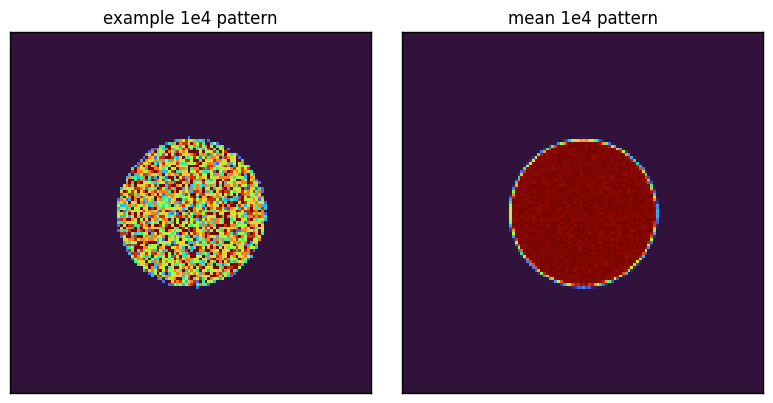

In [15]:
em.visualization.show_2d(
    [
        noisy_dataset[0,0].array,
        noisy_dataset.mean((0,1)),
    ],
    title=[
        "example 1e4 pattern","mean 1e4 pattern"
    ],
    power=0.5,
    cmap='turbo'
);

In [16]:
direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    noisy_dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=rotation_angle,
    aberration_coefs={"defocus":defocus},
    # device='gpu',
)

  0%|          | 0/6 [00:00<?, ?it/s]

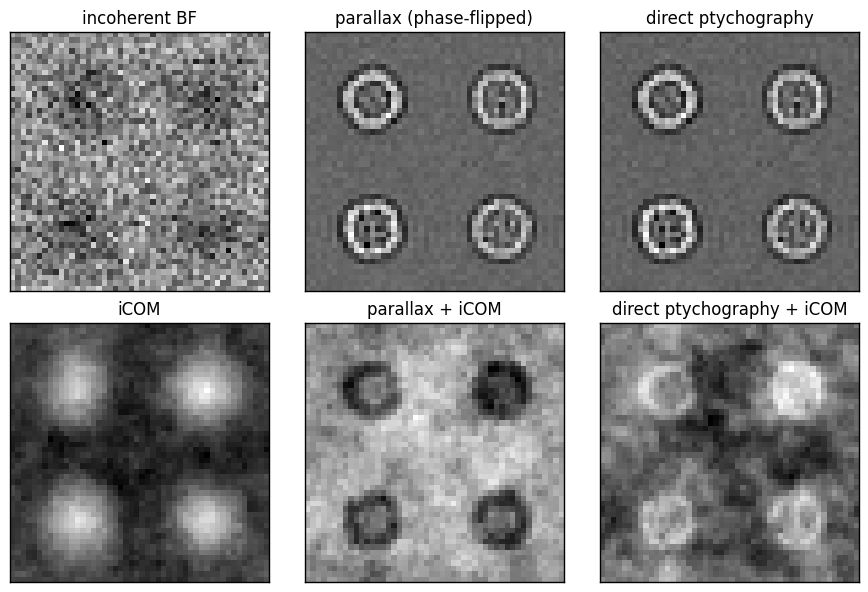

In [17]:
kwargs = {
    "title":[
        ["incoherent BF","parallax (phase-flipped)","direct ptychography",],
        ["iCOM","parallax + iCOM", "direct ptychography + iCOM"]
    ],
    "norm":"minmax",
    "axsize":(3,3),
}

recons = direct_ptycho._reconstruct_all_permutations(
)

em.visualization.show_2d(
    [
        recons[:3],
        recons[3:],
    ],
    **kwargs
);

  0%|          | 0/2100 [00:00<?, ?it/s]

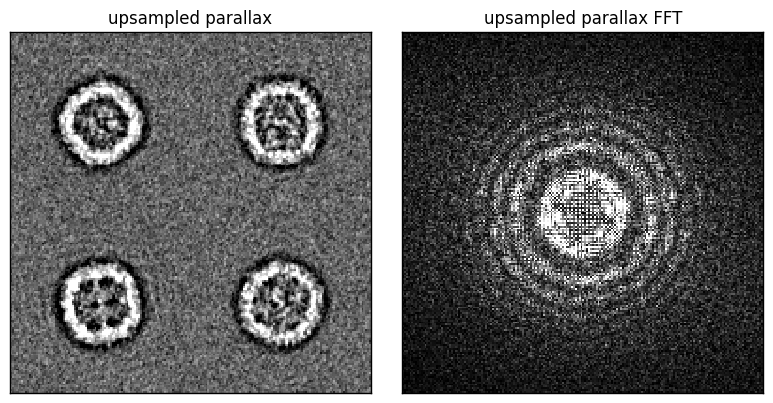

In [20]:
upsampled_parallax_recon = direct_ptycho.reconstruct(
    deconvolution_kernel='parallax',
    upsampling_factor=4,
    max_batch_size=501,
).obj

em.visualization.show_2d(
    [
        upsampled_parallax_recon,
        np.fft.fftshift(
            np.abs(
                np.fft.fft2(
                    upsampled_parallax_recon
                )
            )
        )
    ],
    title=["upsampled parallax","upsampled parallax FFT"]
);